# <center>**Modelagem Sale Documentação**</center>

Este notebook visa elucidar a modelagem adotada para predizer o preço de venda de apartamentos em São Paulo. Serão explorados quatro modelos distintos:

- Regressão Linear
- Regressão Lasso
- Floresta Aleatória
- Boosting

A fim de comparar o desempenho de cada modelo, empregaremos o Erro Quadrático Médio (EQM) como métrica. O modelo que registrar o menor EQM será selecionado para projetar os preços de novos apartamentos.

Ao final deste documento, será definido o modelo que sera utilizado.

### **Bibliotecas e Configurações Gerais**

In [1]:
# Bibliotecas
import pandas as pd
import numpy as np
import ast
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, Lasso
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import GridSearchCV

### **Importando e Ajustando Dados**

In [2]:
# Importando dados
df_sale = pd.read_csv("../data/df_sale_final.csv", index_col=0)

df_sale

,Price,Condo,Size,Rooms,Toilets,Suites,Parking,Elevator,Furnished,Swimming Pool,district_class
0,732600,1000.000000,74,1,2,1,2,1,0,1,B
1,1990000,2400.000000,164,4,5,2,3,1,1,1,B
2,720000,700.000000,70,2,2,1,1,1,0,1,B
3,1680000,1580.000000,155,3,5,3,2,1,0,1,B
4,1200000,900.000000,56,2,2,1,2,0,1,1,B
...,...,...,...,...,...,...,...,...,...,...,...
6297,265000,420.000000,51,2,1,0,1,0,0,0,C
6298,545000,630.000000,74,3,2,1,2,0,0,1,C
6299,515000,1100.000000,114,3,3,1,1,0,0,1,C
6300,345000,48.000000,39,1,2,1,1,0,1,1,C


A variável "district_class" é uma variável categórica que precisa ser transformada em um formato numérico para ser utilizada pelos algoritmos de machine learning. Utilizamos a técnica de codificação one-hot (one-hot encoding) para realizar essa transformação. 

In [3]:
# Codificação One-Hot da variável 'district_class'
df_rent = pd.get_dummies(df_sale, columns=['district_class'], drop_first=True)

### **Divisão de Teste e Treinamento**

In [4]:
# Supondo que a coluna alvo é chamada 'target'
X = df_rent.drop('Price', axis=1)
y = df_rent['Price']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

### **Definição e Treinamento dos Modelos**

#### Regressão Linear

In [5]:
# Regressão Linear
lr_model = LinearRegression()
lr_model.fit(X_train, y_train)
y_pred_lr = lr_model.predict(X_test)
mse_lr = mean_squared_error(y_test, y_pred_lr)
print(f'Linear Regression MSE: {mse_lr}')

Linear Regression MSE: 91131287038.84323


#### Regressão Lasso

A Regressão Lasso é utilizada neste projeto para a seleção de características e regularização, minimizando a complexidade do modelo ao penalizar o coeficiente de termos. O hiperparâmetro principal do Lasso, alpha, controla a força dessa penalização. Para otimizar este hiperparâmetro, empregamos o GridSearchCV, que realiza uma busca exaustiva sobre os valores especificados de alpha (0.01, 0.1, 1, 10, 100), utilizando validação cruzada com 5 folds para avaliar a eficácia de cada configuração baseada no erro quadrático médio negativo. Esse método assegura a escolha do melhor alpha, equilibrando a precisão do modelo e sua capacidade de generalização, conforme demonstrado pelo menor erro quadrático médio obtido nos dados de teste.

In [8]:
# Definindo os hiperparâmetros para GridSearchCV
lasso_params = {
    'alpha': [0.01, 0.1, 1, 10, 100]
}

lasso_model = Lasso()
lasso_grid = GridSearchCV(lasso_model, lasso_params, cv=5, scoring='neg_mean_squared_error')
lasso_grid.fit(X_train, y_train)

# Melhor modelo e avaliação
best_lasso = lasso_grid.best_estimator_
y_pred_lasso = best_lasso.predict(X_test)
mse_lasso = mean_squared_error(y_test, y_pred_lasso)
print(f'Lasso Regression MSE: {mse_lasso}')
print(f'Melhores Hiperparâmetros Lasso: {lasso_grid.best_params_}')

Lasso Regression MSE: 91131297335.41063
Melhores Hiperparâmetros Lasso: {'alpha': 0.01}


Durante a modelagem utilizando a regressão Lasso, otimizamos o hiperparâmetro alpha através de validação cruzada, resultando em um valor de 0.01. Observamos que o erro quadrático médio (MSE) obtido com a regressão Lasso foi muito próximo ao da regressão linear multivariada, indicando que a penalização aplicada pelo Lasso foi mínima e não trouxe uma melhoria significativa no ajuste do modelo.

Esses resultados sugerem que as variáveis preditoras utilizadas têm uma influência significativa sobre a variável target, pois a regressão linear simples (sem penalização) apresentou desempenho semelhante ao modelo penalizado. A baixa penalização (alpha=0.01) implica que a maioria dos coeficientes das variáveis não foram reduzidos a zero, indicando que todas as variáveis preditoras são importantes para a predição.

Dessa forma, concluímos que a regressão linear multivariada já fornece um bom ajuste para os dados, e a adição de penalização via Lasso não se mostrou vantajosa neste contexto específico.

In [9]:
# Exibir os coeficientes do modelo Lasso treinado
coef_df = pd.DataFrame({'Feature': X_train.columns, 'Coefficient': best_lasso.coef_})
coef_df = coef_df.sort_values(by='Coefficient', ascending=False)
print(coef_df)

             Feature    Coefficient
5            Parking  107479.963493
4             Suites  100056.665784
8      Swimming Pool   27697.854234
1               Size    2564.190395
0              Condo     704.542908
6           Elevator   -6764.959288
7          Furnished  -13717.243517
3            Toilets  -35538.887053
2              Rooms  -55047.694150
9   district_class_B -316254.532486
11  district_class_D -418210.771583
10  district_class_C -419434.665399


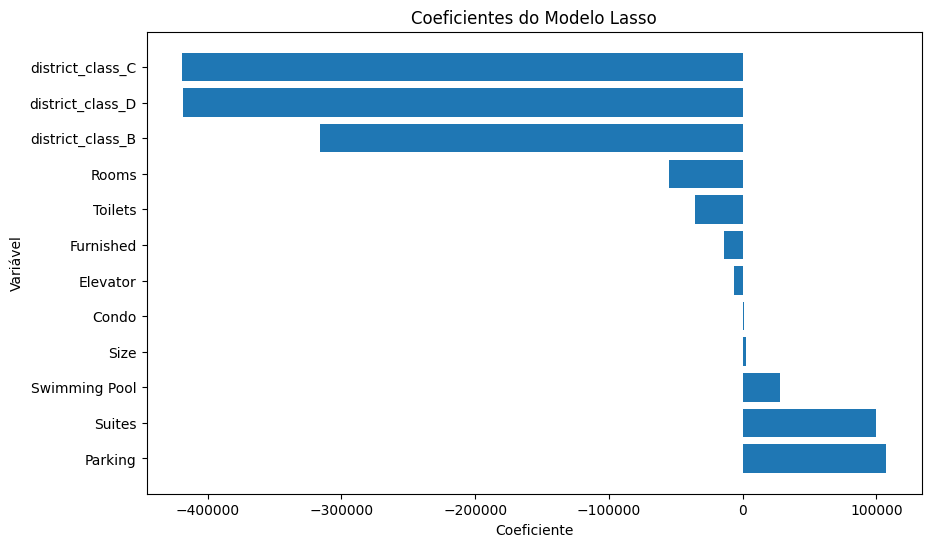

In [10]:
import matplotlib.pyplot as plt

# Plotar os coeficientes do modelo Lasso
plt.figure(figsize=(10, 6))
plt.barh(coef_df['Feature'], coef_df['Coefficient'])
plt.xlabel('Coeficiente')
plt.ylabel('Variável')
plt.title('Coeficientes do Modelo Lasso')
plt.show()

#### Floresta Aleatória

A Floresta Aleatória é um método de aprendizado de máquina baseado em árvores de decisão, que opera pela construção de múltiplas árvores de decisão durante o treinamento e produzindo a média das previsões dessas árvores para obter resultados mais precisos e estáveis. Este modelo é particularmente útil para lidar com problemas de regressão e classificação em grandes conjuntos de dados, pois oferece uma boa performance e é capaz de modelar interações complexas entre as variáveis.

No código apresentado, o modelo ``RandomForestRegressor`` é utilizado, adequado para problemas de regressão. Para otimizar o desempenho do modelo, utiliza-se o GridSearchCV, uma técnica que realiza uma busca exaustiva sobre especificados valores de hiperparâmetros. Os hiperparâmetros ajustados incluem:

- n_estimators: número de árvores na floresta. Valores testados são 100, 200 e 300.
- max_depth: a profundidade máxima das árvores. Testa-se desde árvores com profundidade ilimitada até uma profundidade máxima de 30.
- min_samples_split: o número mínimo de amostras necessárias para dividir um nó interno. Os valores testados são 2, 5 e 10.
- min_samples_leaf: o número mínimo de amostras requeridas para ser um nó folha. Os valores são 1, 2 e 4.

A busca pelo melhor hiperparâmetro foi realizada utilizando o código a seguir:

****

```python
# Definindo os hiperparâmetros para GridSearchCV
rf_params = {
    'n_estimators': [100, 200, 300],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

rf_model = RandomForestRegressor(random_state=42)
rf_grid = GridSearchCV(rf_model, rf_params, cv=5, scoring='neg_mean_squared_error')
rf_grid.fit(X_train, y_train)

# Salvando resultados em um arquivo csv
pd.DataFrame(rf_grid.cv_results_).to_csv("grid_rf_results_sale.csv")
```
****
Para evitar a necessidade de realizar a busca pelos hiperparâmetros novamente, o que demanda um tempo de processamento considerável, os resultados foram salvos em um arquivo CSV chamado ``grid_rf_results_sale.csv``.

In [12]:
# Lendo resultados já calculados do grid
rf_grid_results = pd.read_csv("grid_rf_results_sale.csv", index_col=0)

best_rf = ast.literal_eval(rf_grid_results.sort_values("rank_test_score")["params"].reset_index(drop=True)[0])

best_rf

{'max_depth': 10,
 'min_samples_leaf': 2,
 'min_samples_split': 5,
 'n_estimators': 300}

In [13]:
# Treinando modelo com os hiperparametros otimizados
rf_final = RandomForestRegressor(random_state=42,
                                 max_depth=best_rf["max_depth"],
                                  min_samples_leaf=best_rf["min_samples_leaf"], 
                                  min_samples_split=best_rf["min_samples_split"], 
                                  n_estimators=best_rf["n_estimators"])

rf_final.fit(X_train, y_train)

y_pred_rf = rf_final.predict(X_test)
mse_rf = mean_squared_error(y_test, y_pred_rf)
print(f'Random Forest MSE: {mse_rf}')
print(f'Melhores Hiperparâmetros Random Forest: {best_rf}')

Random Forest MSE: 66646510828.02553
Melhores Hiperparâmetros Random Forest: {'max_depth': 10, 'min_samples_leaf': 2, 'min_samples_split': 5, 'n_estimators': 300}


#### XGBoost

O XGBoost (eXtreme Gradient Boosting) é um algoritmo avançado de aprendizado supervisionado que utiliza o método de boosting de gradiente. É conhecido por sua eficiência em velocidade e desempenho, sendo amplamente utilizado em competições de ciência de dados devido à sua habilidade de lidar com grandes conjuntos de dados e sua eficácia em problemas de classificação e regressão.

No trecho de código apresentado, o modelo XGBRegressor é configurado com um estado aleatório fixo para garantir a consistência dos resultados. O objetivo é ajustar vários hiperparâmetros usando o GridSearchCV, que executa uma busca exaustiva sobre os hiperparâmetros especificados para encontrar a melhor configuração. Os hiperparâmetros ajustados incluem:


- n_estimators: número de árvores construídas pelo modelo, com valores testados de 100, 200 e 300.
- learning_rate: taxa de aprendizagem que controla a contribuição de cada árvore no modelo final, testada em 0.01, 0.1 e 0.2.
- max_depth: a profundidade máxima de cada árvore, com valores de 3, 5 e 7 testados para evitar sobreajuste.
- subsample: a fração de amostras usadas para treinar cada árvore, com valores entre 0.8 e 1.0, que ajuda a controlar o sobreajuste.
- colsample_bytree: a fração de colunas (features) usadas para cada árvore, também testada entre 0.8 e 1.0 para regularização.

Assim como no caso da floresta aleatória, a busca pelos hiperparâmetros foi realizada pelo código abaixo e os resultados foram salvos em um arquivo CSV:

```python
# Definindo os hiperparâmetros para GridSearchCV
xgb_params = {
    'n_estimators': [100, 200, 300],
    'learning_rate': [0.01, 0.1, 0.2],
    'max_depth': [3, 5, 7],
    'subsample': [0.8, 0.9, 1.0],
    'colsample_bytree': [0.8, 0.9, 1.0]
}

xgb_model = XGBRegressor(random_state=42)
xgb_grid = GridSearchCV(xgb_model, xgb_params, cv=5, scoring='neg_mean_squared_error')
xgb_grid.fit(X_train, y_train)

# Salvando resultados em um arquivo csv
pd.DataFrame(xgb_grid.cv_results_).to_csv("grid_boosting_results_sale.csv")
```

Em seguida, o arquivo ``grid_boosting_results_sale.csv`` será importado com todos os resultados do grid.

In [15]:
# Lendo resultados já calculados do grid
xgb_grid_results = pd.read_csv("grid_boosting_results_sale.csv", index_col=0)

best_xgb_result = ast.literal_eval(xgb_grid_results.sort_values("rank_test_score")["params"].reset_index(drop=True)[0])

best_xgb_result

{'colsample_bytree': 1.0,
 'learning_rate': 0.2,
 'max_depth': 3,
 'n_estimators': 100,
 'subsample': 1.0}

In [16]:
# Treinando modelo final com hiperparametros otimizados
xgb_final = XGBRegressor(random_state = 42,
                         colsample_bytree=best_xgb_result["colsample_bytree"],
                         learning_rate=best_xgb_result["learning_rate"],
                         max_depth=best_xgb_result["max_depth"],
                         n_estimators=best_xgb_result["n_estimators"],
                         subsample=best_xgb_result["subsample"])

xgb_final.fit(X_train, y_train)


y_pred_xgb = xgb_final.predict(X_test)
mse_xgb = mean_squared_error(y_test, y_pred_xgb)
print(f'XGBoost MSE: {mse_xgb}')
print(f'Melhores Hiperparâmetros XGBoost: {best_xgb_result}')

XGBoost MSE: 61603869460.28341
Melhores Hiperparâmetros XGBoost: {'colsample_bytree': 1.0, 'learning_rate': 0.2, 'max_depth': 3, 'n_estimators': 100, 'subsample': 1.0}


### **Comparando Resultados**

In [17]:
# Comparação dos Resultados
model_results = {
    'Linear Regression': mse_lr,
    'Lasso Regression': mse_lasso,
    'Random Forest': mse_rf,
    'XGBoost': mse_xgb
}

best_model = min(model_results, key=model_results.get)
print(f'O melhor modelo é {best_model} com um EQM de {model_results[best_model]}')

O melhor modelo é XGBoost com um EQM de 61603869460.28341
